In [6]:
import importlib.util
def module_from_file(module_name, file_path): #The code that imports the file which originated the training with all the instructions
            spec = importlib.util.spec_from_file_location(module_name, file_path)
            module = importlib.util.module_from_spec(spec)
            spec.loader.exec_module(module)
            return module

from importlib import import_module
#foo = import_module(fold_folder+'/Funs.py', package=None)


folder = '/scratchx/gmiloshe/Climate-Learning/VAE/xforanalogs/NA24by48/Z8/yrs500/interT15fw20.1.20lrs4'
foo = module_from_file("foo", f'{folder}/Funs.py')

import random as rd  
from scipy.stats import norm
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.metrics import log_loss

tff = foo.tff # tensorflow routines 
ut = foo.ut # utilities
ln = foo.ln #Learn2_new.py
print("==Checking GPU==")
import tensorflow as tf
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

print("==Checking CUDA==")
tf.test.is_built_with_cuda()

import sys
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
sys.path.insert(1, '../ERA')

print("==Reading data==")

year_permutation = np.load(f'{folder}/year_permutation.npy')

run_vae_kwargs = ut.json2dict(f"{folder}/config.json")
T = ut.extract_nested(run_vae_kwargs, 'T')
if (ut.keys_exists(run_vae_kwargs, 'label_period_start') and ut.keys_exists(run_vae_kwargs, 'label_period_end')):
    label_period_start = ut.extract_nested(run_vae_kwargs, 'label_period_start')
    label_period_end = ut.extract_nested(run_vae_kwargs, 'label_period_end')
    time_start = ut.extract_nested(run_vae_kwargs, 'time_start')
    time_end = ut.extract_nested(run_vae_kwargs, 'time_end')
    
    
n_days = time_end-time_start-T+1
n_days

import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd

def Compare_Scores(runs, committor_filename='committor.pkl', setnn=10, setcheck=10, savename='./Images/analog',marker='.',linestyle='solid',alpha=0.1,dpi=200):
        """_summary_
                Computes and plots scores of training given the folders given in dictionary runs
        Args:
            runs (_type_): _description_
                Dictionary for the runs. The value contains the folder name, or if we want to shift the plots in days, it can be a list, of [folder,shift]
            committor_filename (string, optional): 
                the filename that stores the values of committor and skill
            setnn (int, optional): _description_. Defaults to 10.
                number of nearest neigbhors to plot 
            setcheck (int, optional): _description_. Defaults to 10.
            savename (str, optional): _description_. Defaults to './Images/analog_taus.png'.
                destination to save the figure
            marker (string,optional): 
                the markers to be used when decorating the plot. Defaults to '.'
            linestyle (string,optional):
                linestyle of the plots. Defaults to 'solid'
            alpha (float, optional):
                alpha for the filled lines which display +- uncertainty. Defaults to 0.1
            dpi (float, optional):
                dpi when saving the figure. Defaults to 200
        """
        fig2 = plt.figure()
        fig2.set_size_inches(15, 4)
        ax = fig2.subplots(nrows=1, ncols=3)
        for name, folder in runs.items():
                print(name)
                if isinstance(folder, list):
                        shift = folder[1]
                        folder = folder[0]
                else:
                        shift = 0
                with open(f'{folder}/committor.pkl', "rb") as open_file:
                        committor_dictionary = pickle.load(open_file)
                #committor = committor_dictionary['committor']
                print(committor_dictionary.keys())
                print(committor_dictionary['RunFolds_kwargs_default'])
                delay = ut.extract_nested(committor_dictionary['RunFolds_kwargs_default'],'delay')
                chain_step = ut.extract_nested(committor_dictionary['RunFolds_kwargs_default'],'chain_step')
                skill = committor_dictionary['skill']
                skill = []
                for check, value_check in committor_dictionary['skill'].items():
                        score_nn = []
                        for nn, value_nn in value_check.items():     
                                score_fold = []
                                for fold, value_fold in value_nn.items():
                                        score_fold.append(pd.DataFrame([value_fold], columns = -delay*chain_step) )
                                score_nn.append(pd.concat(score_fold, keys=value_nn.keys(),names=['fold', None]))
                        skill.append(pd.concat(score_nn, keys=value_check.keys(),names=['nn','fold', None]))
                skill = pd.concat(skill, keys =committor_dictionary['skill'].keys(), names=['check','nn','fold', None] )
                meanskill = skill.groupby(['check', 'nn']).mean() #.loc[(slice(None), 1), 'skill'] #.droplevel(level=(1,2)) 
                stdskill = skill.groupby(['check', 'nn']).std()
                tauarray = np.array([-tau for tau in meanskill])
                meanskilarray = np.array([meanskill[tau].max() for tau in meanskill])
                stdskillarray = np.array([stdskill[tau][meanskill[tau].idxmax()] for tau in stdskill])
                
                ax[0].plot(tauarray+shift, meanskilarray,label=name, marker=marker,linestyle=linestyle)
                ax[0].fill_between(tauarray+shift,meanskilarray-stdskillarray,meanskilarray+stdskillarray,alpha=alpha)
        
                meanskill[0][(slice(None),setnn)].plot(ax = ax[1], label=f'{name}: nn = {setnn}', marker=marker,linestyle=linestyle)
                if np.any(meanskill[0].index.isin([ setcheck], level='check')): # check if check exists
                    print("here : ",meanskill[0].loc[pd.IndexSlice[setcheck,:]])
                    meanskill[0].loc[pd.IndexSlice[setcheck,:]].plot(ax = ax[2], label=rf'{name}: $\alpha_0$ = {setcheck}', marker=marker,linestyle=linestyle)
                else:
                    print(f"Coudln't find {setcheck = } in  eanskill[0]")
                for j in list(meanskill.columns):
                        print(f"{meanskill[j].max():.2f}+-{stdskill[j][meanskill[j].idxmax()]:.2f}, {meanskill[j].idxmax()[0]}, {meanskill[j].idxmax()[1]}")
        ax[1].set_xscale('log')
        ax[2].set_xscale('log')
        #ax1.set_ylabel('skill')
        #ax.set_ylim([0,0.5])
        #ax.set_yscale("log")
        for i in range(3):
                ax[i].legend(loc='best', fancybox=True, framealpha=0.5)
                ax[i].grid(True)
                ax[i].set_ylabel('NLS')
                ax[i].set_ylim([0,0.45])
        ax[0].set_xlabel(r'$\tau$')
        ax[1].set_xlabel(r'$\alpha_0$')
        ax[2].set_xlabel('Number of Nearest Neighbors')
        fig2.savefig(savename,dpi=dpi,bbox_inches='tight')
        fig2.savefig(f"{savename}_taus.png", bbox_inches=ln.ef.full_extent(ax[0]).transformed(fig2.dpi_scale_trans.inverted()), dpi=dpi)
        fig2.savefig(f'{savename}_alphas.png', bbox_inches=ln.ef.full_extent(ax[1]).transformed(fig2.dpi_scale_trans.inverted()), dpi=dpi)
        fig2.savefig(f'{savename}_analog_nns.png', bbox_inches=ln.ef.full_extent(ax[1]).transformed(fig2.dpi_scale_trans.inverted()), dpi=dpi)
        return fig2, ax

def Compare_CNNs(folder, folders, fig2=None, ax=None, savename='./Images/analog',marker='.',linestyle='solid',alpha=0.1,dpi=200):
        if fig2 is None:
                fig2 = plt.figure()
                fig2.set_size_inches(15, 4)
        if ax is None:
                ax = fig2.subplots(nrows=1, ncols=3)
        for folder in folders:
                runs = ut.json2dict(f"{folder}/runs.json")
                runs_grouped_list = ln.make_groups(runs,config_dict_flat={'tau':0})
                config = ut.json2dict(f"{folder}/config.json")
                percent = ut.extract_nested(config, 'percent')
                area = ut.extract_nested(config, 'area')
                nfolds = ut.extract_nested(config, 'nfolds')
                
                for k in range(len(runs_grouped_list)):
                        if runs_grouped_list[k]['args'] == {}:
                                break
                
                print(f'{k = }')
                print(f"{runs_grouped_list[k]['args'] = }")
                for runs in [runs_grouped_list[k]]:
                        dg = []
                        taus = runs['tau']
                        for tau_index, value in enumerate(runs['runs']):
                                #print(value['name'])
                                if value['status'] != 'FAILED':
                                        data= pd.read_csv(f"{folder}/{value['name']}/fold_{0}/history.csv")
                                        #print(tau)
                                        df = []
                                        for i in range(nfolds):
                                                df.append(pd.read_csv(f"{folder}/{value['name']}/fold_{i}/history.csv"))
                                        #print(f'{len(df) = }')
                                        dg.append(pd.concat(df, keys=range(10),names=['fold', None]))
                                else:
                                        print(f'{tau_index = }')
                                        taus.pop(tau_index)
                        dg_frame = pd.concat(dg, keys=taus,names=['tau','fold', None])
                        maxskill = -(percent/100.)*np.log(percent/100.)-(1-percent/100.)*np.log(1-percent/100.)
                        dg_frame['val_CustomSkill'] = (maxskill - dg_frame['val_CustomLoss'])/maxskill
                        dg_fold_mean = dg_frame.groupby(['tau','epoch']).mean()  # We need to compute fold-wise mean
                        dg_idxmax = dg_fold_mean.loc[:,'val_CustomSkill'].groupby(['tau']).idxmax() # Now we compute the indices for which the val_CustomSkill is maximal because we need to apply them to standard deviation as well
                        dg_foldmean_maxskill_mean = dg_frame.groupby(['tau','epoch']).mean().loc[dg_idxmax] #Now we are in a position to also compute standard deviation and mean for those columns which correspond to the optimal customskill
                        dg_foldmean_maxskill_std = dg_frame.groupby(['tau','epoch']).std().loc[dg_idxmax]
                        ax[0].fill_between(-dg_foldmean_maxskill_std['val_CustomSkill'].droplevel(level=1).index+2,
                                           dg_foldmean_maxskill_mean['val_CustomSkill'].values-dg_foldmean_maxskill_std['val_CustomSkill'].values,
                                           dg_foldmean_maxskill_mean['val_CustomSkill'].values+dg_foldmean_maxskill_std['val_CustomSkill'].values,alpha=alpha)
                        ax[0].plot(-dg_foldmean_maxskill_std['val_CustomSkill'].droplevel(level=1).index+2,dg_foldmean_maxskill_mean['val_CustomSkill'].values, 
                                   label=f'{area} CNN', marker=marker, linestyle=linestyle)

        ax[1].set_xscale('log')
        ax[2].set_xscale('log')
        #ax1.set_ylabel('skill')
        #ax.set_ylim([0,0.5])
        #ax.set_yscale("log")
        for i in range(3):
                ax[i].legend(loc='best', fancybox=True, framealpha=0.5)
                ax[i].grid(True)
                ax[i].set_ylabel('NLS')
                ax[i].set_ylim([0,0.45])
        ax[0].set_xlabel(r'$\tau$')
        fig2.savefig(savename,dpi=dpi,bbox_inches='tight')
        fig2.savefig(f"{savename}_taus.png", bbox_inches=ln.ef.full_extent(ax[0]).transformed(fig2.dpi_scale_trans.inverted()),dpi=dpi)
        return runs_grouped_list


==Checking GPU==
==Checking CUDA==
==Reading data==


2023-03-07 14:50:13.362023: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:0 with 21947 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:73:00.0, compute capability: 8.6
2023-03-07 14:50:13.364747: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:0 with 21947 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:73:00.0, compute capability: 8.6


In [2]:
fold = 5
with open(f'xforanalogs/NA24by48/global_logit/yrs500/interT15/q.pkl', "rb") as open_file:
    q_dictionary = pickle.load(open_file)
with open(f'xforanalogs/NA24by48/global_logit/yrs500/interT15/committor_tr.pkl', "rb") as open_file:
    committor_dictionary = pickle.load(open_file)

Y_tr_summer = np.load(f'../PLASIM/xmodels/T15/NAE/France/CNNyrs500/0/fold_{fold}/Y_tr.npy')
Y_tr = np.load(f'xforanalogs/NA24by48/global_logit/yrs500/interT15/fold_{fold}/Y_tr.npy')
Y_va = np.load(f'xforanalogs/NA24by48/global_logit/yrs500/interT15/fold_{fold}/Y_va.npy')
print(f"{q_dictionary['q'][3][50][10].shape = }, {committor_dictionary['committor'][50][10][3].shape = }, {Y_tr.shape = } ")

q_dictionary['q'][3][50][10].shape = (47250, 1, 6), committor_dictionary['committor'][50][10][3].shape = (34200, 6), Y_tr.shape = (47250,) 


In [3]:
yr,dy = np.where(Y_tr.reshape(450,-1))[0][444], np.where(Y_tr.reshape(450,-1))[1][444]
print(f'{yr = },{dy = }')

yr = 54,dy = 66


In [4]:
print(f"{q_dictionary['q'][fold][50][1].reshape(450,-1,6)[yr, dy-10:dy+10,0]}")
print(f"{q_dictionary['q'][fold][50][1].reshape(450,-1,6)[yr, dy-10:dy+10,1]}")
print(f"{q_dictionary['q'][fold][50][1].reshape(450,-1,6)[yr, dy-10:dy+10,2]}")
print(f"{1.*Y_tr.reshape(450,-1)[yr, dy-10:dy+10]}")

[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]


In [5]:
print(committor_dictionary['committor'][50][1][fold].reshape(450,-1,6)[yr, dy-10-15:dy+10-15,0])
print(committor_dictionary['committor'][50][5][fold].reshape(450,-1,6)[yr, dy-10-15:dy+10-15,0])
print(committor_dictionary['committor'][50][10][fold].reshape(450,-1,6)[yr, dy-10-15:dy+10-15,0])
print(1.*Y_tr_summer.reshape(450,-1)[yr, dy-10-15:dy+10-15])

[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
[0.     0.008  0.0433 0.0961 0.1254 0.1871 0.3098 0.2976 0.2762 0.3193
 0.3921 0.3654 0.4831 0.3658 0.4033 0.3404 0.5103 0.3946 0.2492 0.2481]
[0.0599 0.05   0.0806 0.125  0.1473 0.0955 0.1643 0.1466 0.104  0.1514
 0.2837 0.4167 0.3999 0.4696 0.4366 0.5006 0.5401 0.3264 0.4227 0.3037]
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]


In [6]:
yr = 100
dy = 50
ty = 5

print([committor_dictionary['committor'][50][10][3].reshape(450,-1,6)[yr,dy+i,ty] for i in range(12)])
print([q_dictionary['q'][3][50][10].reshape(450,-1,6)[yr,dy+i,ty] for i in range(12)])


[0.131, 0.1943, 0.1725, 0.1838, 0.2011, 0.1967, 0.214, 0.2176, 0.2004, 0.1954, 0.2182, 0.2521]
[0.131, 0.1943, 0.1725, 0.1838, 0.2011, 0.1967, 0.214, 0.2176, 0.2004, 0.1954, 0.2182, 0.2521]


In [7]:
yr = 121
dy = 50
ty = 4

print([committor_dictionary['committor'][50][10][3].reshape(450,-1,6)[yr,dy+i,ty] for i in range(12)])
print([q_dictionary['q'][3][50][10].reshape(450,-1,6)[yr,dy+i,ty] for i in range(12)])


[0.003, 0.0073, 0.0045, 0.0061, 0.0105, 0.0102, 0.0094, 0.0134, 0.0086, 0.0119, 0.0091, 0.009]
[0.0026, 0.0013, 0.0023, 0.003, 0.0073, 0.0045, 0.0061, 0.0105, 0.0102, 0.0094, 0.0134, 0.0086]


In [8]:
yr = 121
dy = 50
ty = 3

print([committor_dictionary['committor'][50][10][3].reshape(450,-1,6)[yr,dy+i,ty] for i in range(12)])
print([q_dictionary['q'][3][50][10].reshape(450,-1,6)[yr,dy+i,ty] for i in range(12)])


[0.0032, 0.0071, 0.0066, 0.0058, 0.0073, 0.0063, 0.0082, 0.0075, 0.006, 0.0087, 0.0007, 0.0031]
[0.0007, 0.0005, 0.0005, 0.0009, 0.0037, 0.0022, 0.0032, 0.0071, 0.0066, 0.0058, 0.0073, 0.0063]


Comparing raw analog method to the CNN 

NA/3scalars/
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'windwsize': 30, 'start_calendar_day': None, 'start_day_set': 'va', 'allowselfanalogs': True, 'removeoutsidemovingwindow': False, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [2, 3, 5, 10, 20, 50], 'delay': array([0, 1, 2, 3, 4, 5]), 'num_steps': None}}}
here :  nn
2    -0.645287
3     0.159361
5     0.352837
10    0.382369
20    0.378730
50    0.367985
Name: 0, dtype: float64
0.40+-0.05, 50.0, 10
0.29+-0.05, 50.0, 10
0.22+-0.05, 50.0, 10
0.19+-0.06, 10.0, 10
0.18+-0.06, 10.0, 10
0.18+-0.05, 10.0, 10
k = 0
runs_grouped_list[k]['args'] = {}


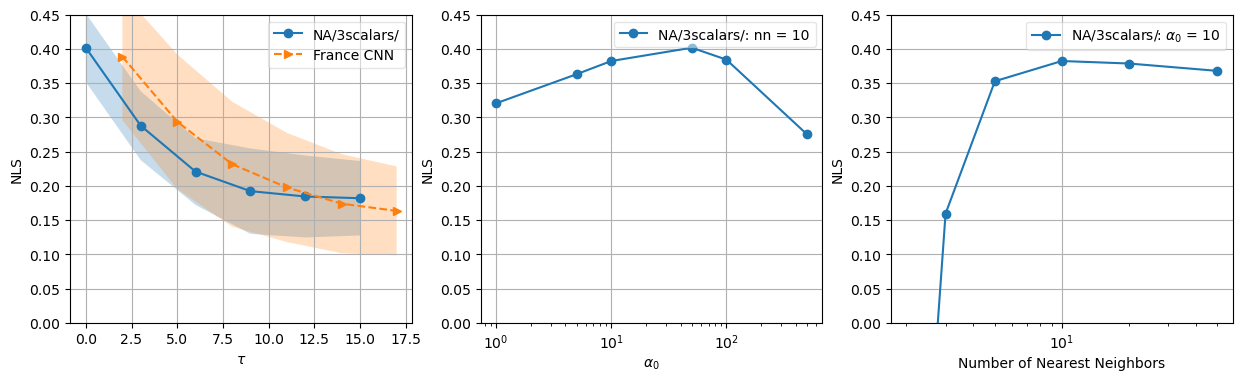

In [17]:
runs = {'NA/3scalars/' : '/scratchx/gmiloshe/Climate-Learning/VAE/xforanalogs/NA24by48/global_logit/yrs500/interT15/'
        }

fig2, ax = Compare_Scores(runs, setnn=10, setcheck=10, savename='./Images/analog', marker='o', alpha=0.25)

test=Compare_CNNs(folder, ['/scratchx/gmiloshe/Climate-Learning/PLASIM/xmodels/T15/NAE/France/yrs500/'], fig2=fig2, ax=ax, savename='./Images/analog', marker='>', linestyle='dashed', alpha=0.25)

Comparing raw analog method to VAE analog with all three fields passed through VAE

Raw Analogs
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'windwsize': 30, 'start_calendar_day': None, 'start_day_set': 'va', 'allowselfanalogs': True, 'removeoutsidemovingwindow': False, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [2, 3, 5, 10, 20, 50], 'delay': array([0, 1, 2, 3, 4, 5]), 'num_steps': None}}}
here :  nn
2    -0.645287
3     0.159361
5     0.352837
10    0.382369
20    0.378730
50    0.367985
Name: 0, dtype: float64
0.40+-0.05, 50.0, 10
0.29+-0.05, 50.0, 10
0.22+-0.05, 50.0, 10
0.19+-0.06, 10.0, 10
0.18+-0.06, 10.0, 10
0.18+-0.05, 10.0, 10
North Atlantic ResNet (16)
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'allowselfanalogs': True, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [1, 2, 3, 5, 10, 20, 50, 100], 'de

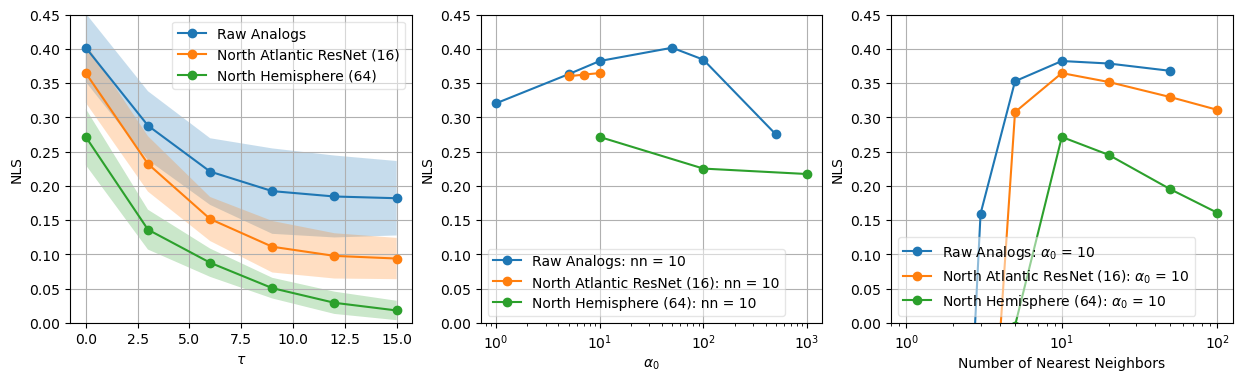

In [19]:
runs = {'Raw Analogs' : '/scratchx/gmiloshe/Climate-Learning/VAE/xforanalogs/NA24by48/global_logit/yrs500/interT15/'
        #,'NA/Z8//fw20.1.20lrs4' : './xforanalogs/NA24by48/Z8/yrs500/interT15fw20.1.20lrs4/'
        #,'NA/Z8//fw20.4.20lrs4' : './xforanalogs/NA24by48/Z8/yrs500/interT15fw20.4.20lrs4/'
        #,'NA/Z8//fw20.1.20kl.5.5lrs4' : './xforanalogs/NA24by48/Z8/yrs500/interT15fw20.1.20kl.5.5lrs4/'
        #,'NA/Z8/yrs500/fw20.1.20skip2' : './xforanalogs/NA24by48/Z8/yrs500/interT15fw20.1.20skip2/'
        #,'NA/Z16//fw20.1.20lrs4' : './xforanalogs/NA24by48/Z16/yrs500/interT15fw20.1.20lrs4/'
        ,'North Atlantic ResNet (16)' : '/scratchx/gmiloshe/Climate-Learning/VAE/xforanalogs/NA24by48/Z16/yrs500/interT15fw20.1.20kl.99.01skip2/'
        ,'North Hemisphere (64)' : '/scratchx/gmiloshe/Climate-Learning/VAE/xforanalogs/NH24by128/Z64/yrs500/interT15fw20.1.20lrs4/'
        }

test=Compare_Scores(runs, setnn=10, setcheck=10, savename='./Images/analog', marker='o', alpha=0.25)

Comparing raw analog with analog VAE where only ZG has passed through autoencoder

France SWG
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'windwsize': 30, 'start_calendar_day': None, 'start_day_set': 'va', 'allowselfanalogs': True, 'removeoutsidemovingwindow': False, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [2, 3, 5, 10, 20, 50], 'delay': array([0, 1, 2, 3, 4, 5]), 'num_steps': None}}}
here :  nn
2    -0.654385
3     0.147260
5     0.348281
10    0.376861
20    0.376024
50    0.365412
Name: 0, dtype: float64
0.40+-0.03, 50.0, 10
0.29+-0.02, 50.0, 10
0.22+-0.02, 50.0, 10
0.19+-0.02, 10.0, 20
0.18+-0.02, 10.0, 10
0.18+-0.03, 10.0, 10
France SWG VAE
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'windwsize': 30, 'start_calendar_day': None, 'start_day_set': 'va', 'allowselfanalogs': True, 'removeoutsidemovingwindow': False, 'RunNeighbors_kwargs': {'

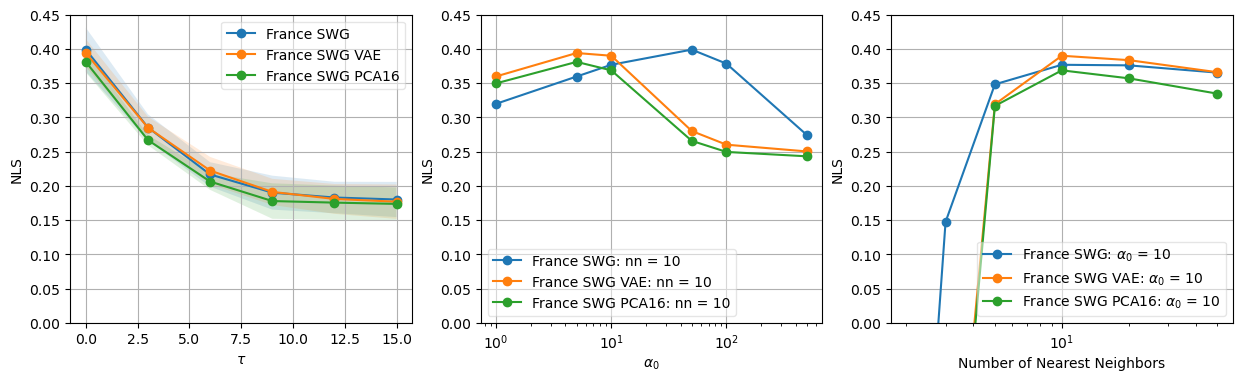

In [20]:
runs = {#'France SWG' : './xforanalogs/NA24by48/global_logit/yrs500/interT15/'
        'France SWG' : '/scratchx/gmiloshe/Climate-Learning/VAE/xforanalogs/5fold/T15/NAE/France/yrs500/Z0/globa_logit/'
       #,'France SWG VAE' : './xforanalogs/ZGonlyNA24by48/Z16/yrs500/interT15fw20.1.20ZGskip2/'
        ,'France SWG VAE' : '/scratchx/gmiloshe/Climate-Learning/VAE/xforanalogs/5fold/T15/NAE/France/yrs500/Z16/ZGskip2/'
        #,'North Atlantic (64)' : './xforanalogs/ZGonlyNA24by48/Z64/yrs500/interT15fw20.1.20ZGlrs4/'
        #,'France SWG PCA16' : './xforanalogs/ZGonlyNA24by48/Z16/yrs500/interT15PCA/'
        ,'France SWG PCA16' : '/scratchx/gmiloshe/Climate-Learning/VAE/xforanalogs/5fold/T15/NAE/France/yrs500/Z16/pca/'
}
        
test=Compare_Scores(runs, setnn=10, setcheck=10, savename='./Images/SWGVAEvsPCA', marker='o', linestyle='solid', alpha=0.15, dpi=200)

France SWG
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'windwsize': 30, 'start_calendar_day': None, 'start_day_set': 'va', 'allowselfanalogs': True, 'removeoutsidemovingwindow': False, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [2, 3, 5, 10, 20, 50], 'delay': array([0, 1, 2, 3, 4, 5]), 'num_steps': None}}}
here :  nn
2    -0.645287
3     0.159361
5     0.352837
10    0.382369
20    0.378730
50    0.367985
Name: 0, dtype: float64
0.40+-0.05, 50.0, 10
0.29+-0.05, 50.0, 10
0.22+-0.05, 50.0, 10
0.19+-0.06, 10.0, 10
0.18+-0.06, 10.0, 10
0.18+-0.05, 10.0, 10
France SWG VAE
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'allowselfanalogs': True, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [1, 2, 3, 5, 10, 20, 50, 100], 'delay': array([

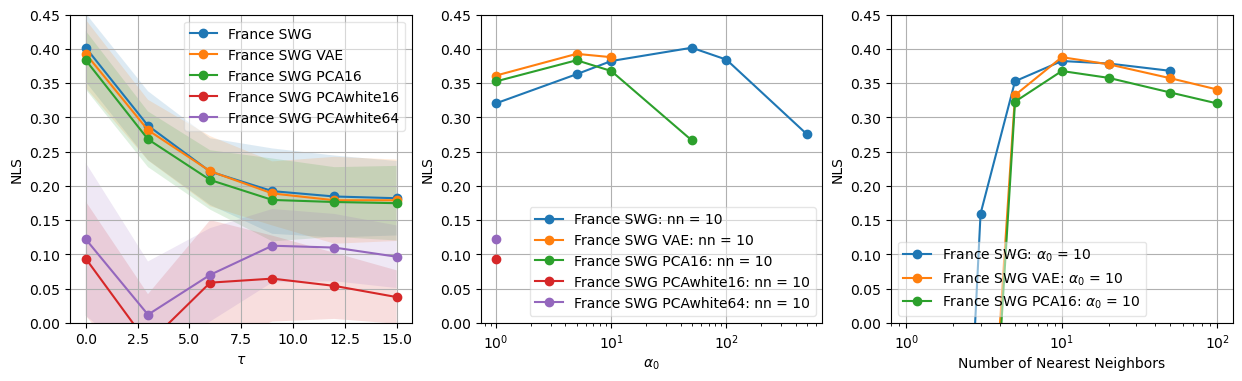

In [21]:
runs = {'France SWG' : '/scratchx/gmiloshe/Climate-Learning/VAE/xforanalogs/NA24by48/global_logit/yrs500/interT15/'
       ,'France SWG VAE' : '/scratchx/gmiloshe/Climate-Learning/VAE/xforanalogs/ZGonlyNA24by48/Z16/yrs500/interT15fw20.1.20ZGskip2/'
        #,'North Atlantic (64)' : '/scratchx/gmiloshe/Climate-Learning/VAE/xforanalogs/ZGonlyNA24by48/Z64/yrs500/interT15fw20.1.20ZGlrs4/'
        ,'France SWG PCA16' : '/scratchx/gmiloshe/Climate-Learning/VAE/xforanalogs/ZGonlyNA24by48/Z16/yrs500/interT15PCA/'
        ,'France SWG PCAwhite16' : '/scratchx/gmiloshe/Climate-Learning/VAE/xforanalogs/NA24by48/Z16/yrs500/interT15PCA/'
        ,'France SWG PCAwhite64' : '/scratchx/gmiloshe/Climate-Learning/VAE/xforanalogs/NA24by48/Z64/yrs500/interT15PCA/'
}
        
test=Compare_Scores(runs, setnn=10, setcheck=10, savename='./Images/SWGVAEvsPCA', marker='o', linestyle='solid', alpha=0.15, dpi=200)

France SWG PCA16
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'allowselfanalogs': True, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [1, 2, 3, 5, 10, 20, 50, 100], 'delay': array([0, 1, 2, 3, 4, 5])}}}
here :  nn
1     -4.445245
2     -1.590812
3     -0.496315
5      0.322966
10     0.367762
20     0.357753
50     0.336321
100    0.320357
Name: 0, dtype: float64
0.38+-0.04, 5.0, 10
0.27+-0.04, 5.0, 10
0.21+-0.04, 5.0, 10
0.18+-0.06, 1.0, 10
0.18+-0.05, 1.0, 100
0.17+-0.05, 1.0, 5
France SWG PCAwhite16
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'windwsize': 30, 'start_calendar_day': None, 'start_day_set': 'va', 'allowselfanalogs': True, 'removeoutsidemovingwindow': False, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [2, 3, 5, 10,

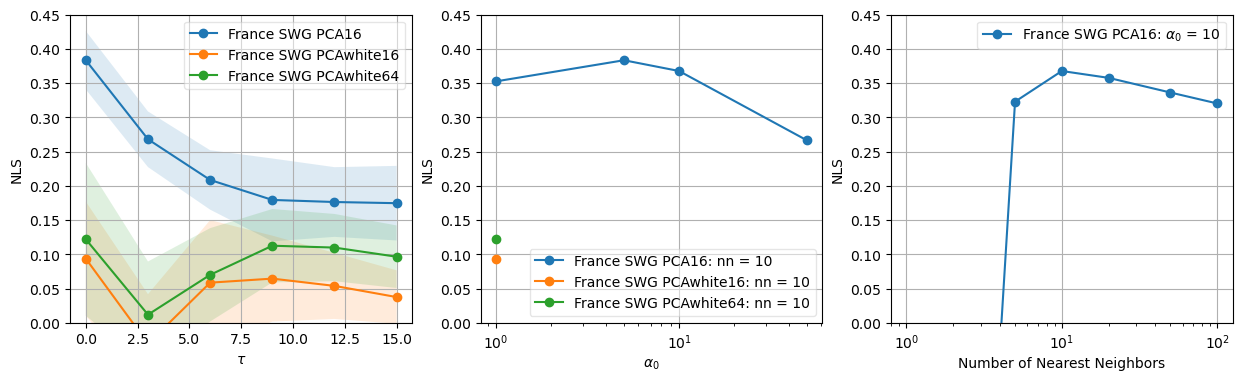

In [22]:
runs = {'France SWG PCA16' : '/scratchx/gmiloshe/Climate-Learning/VAE/xforanalogs/ZGonlyNA24by48/Z16/yrs500/interT15PCA/',
        'France SWG PCAwhite16' : '/scratchx/gmiloshe/Climate-Learning/VAE/xforanalogs/NA24by48/Z16/yrs500/interT15PCA/',
        'France SWG PCAwhite64' : '/scratchx/gmiloshe/Climate-Learning/VAE/xforanalogs/NA24by48/Z64/yrs500/interT15PCA/'
}
        
test=Compare_Scores(runs, setnn=10, setcheck=10, savename='./Images/SWGVAEvsPCA', marker='o', linestyle='solid', alpha=0.15, dpi=200)

Comparing raw analog method with VAE analog 64 with 10 epochs vs 1000 epochs

Raw Analog
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'windwsize': 30, 'start_calendar_day': None, 'start_day_set': 'va', 'allowselfanalogs': True, 'removeoutsidemovingwindow': False, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [2, 3, 5, 10, 20, 50], 'delay': array([0, 1, 2, 3, 4, 5]), 'num_steps': None}}}
here :  nn
2    -0.645287
3     0.159361
5     0.352837
10    0.382369
20    0.378730
50    0.367985
Name: 0, dtype: float64
0.40+-0.05, 50.0, 10
0.29+-0.05, 50.0, 10
0.22+-0.05, 50.0, 10
0.19+-0.06, 10.0, 10
0.18+-0.06, 10.0, 10
0.18+-0.05, 10.0, 10
North Atlantic (64)
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'allowselfanalogs': True, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [1, 2, 3, 5, 10, 20, 50, 100], 'delay': ar

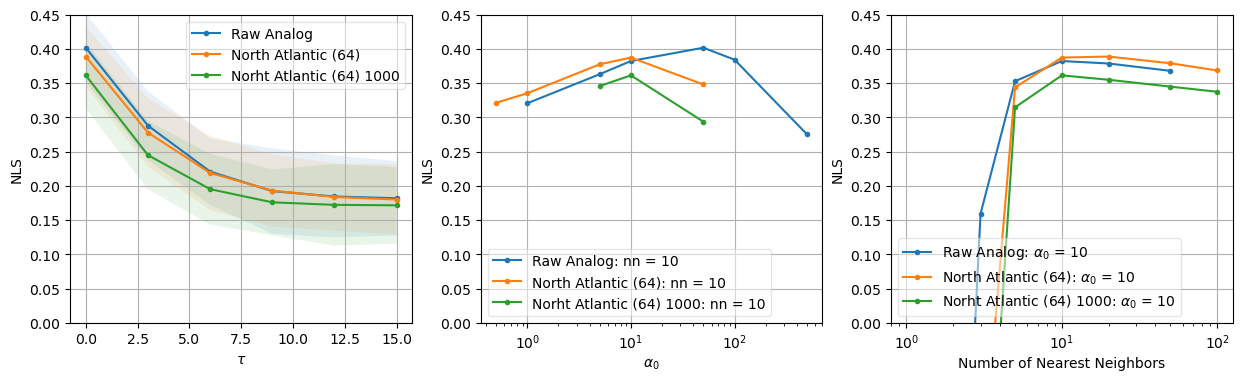

In [23]:
runs = {'Raw Analog' : '/scratchx/gmiloshe/Climate-Learning/VAE/xforanalogs/NA24by48/global_logit/yrs500/interT15/'
        #,'NA/Z8//fw20.1.20lrs4' : './xforanalogs/NA24by48/Z8/yrs500/interT15fw20.1.20lrs4/'
        #,'NA/Z8//fw20.4.20lrs4' : './xforanalogs/NA24by48/Z8/yrs500/interT15fw20.4.20lrs4/'
        #,'NA/Z8//fw20.1.20kl.5.5lrs4' : './xforanalogs/NA24by48/Z8/yrs500/interT15fw20.1.20kl.5.5lrs4/'
        #,'NA/Z8/yrs500/fw20.1.20skip2' : './xforanalogs/NA24by48/Z8/yrs500/interT15fw20.1.20skip2/'
        #,'NA/Z16//fw20.1.20lrs4' : './xforanalogs/NA24by48/Z16/yrs500/interT15fw20.1.20lrs4/'
        #,'NA/Z16//fw20.1.20kl.99.01skip2' : './xforanalogs/NA24by48/Z16/yrs500/interT15fw20.1.20kl.99.01skip2/'
        #,'NH/Z64/fw20.1.20lrs4' : './xforanalogs/NH24by128/Z64/yrs500/interT15fw20.1.20lrs4/'
        #,'ZG' : './xforanalogs/ZGonlyNA24by48/Z8/yrs500/interT15ZGlrs4/'
        #,'ZGfw1.1.1' : './xforanalogs/ZGonlyNA24by48/Z8/yrs500/interT15fw1.1.1ZGlrs4/'
        #,'ZGskip2' : './xforanalogs/ZGonlyNA24by48/Z8/yrs500/interT15ZGskip2/'
        #,'ZGskip2with10epochs' : './xforanalogs/ZGonlyNA24by48/Z8/yrs500/interT15ZGskip2with10epochs/'
        #,'ZGkl.99.01skip2' : './xforanalogs/ZGonlyNA24by48/Z8/yrs500/interT15ZGkl.99.01skip2/'
        #,'North Atlantic ResNet (16)' : './xforanalogs/ZGonlyNA24by48/Z16/yrs500/interT15fw20.1.20ZGskip2/'
        #,'Z64/fw1.1.1' : './xforanalogs/ZGonlyNA24by48/Z16/yrs500/interT15fw1.1.1ZGlrs4/'
        ,'North Atlantic (64)' : '/scratchx/gmiloshe/Climate-Learning/VAE/xforanalogs/ZGonlyNA24by48/Z64/yrs500/interT15fw20.1.20ZGlrs4'
        ,'Norht Atlantic (64) 1000' : '/scratchx/gmiloshe/Climate-Learning/VAE/xforanalogs/ZGonlyNA24by48/Z64/yrs500/interT15fw20.1.20ZGlrs4epoch1000'
        #,'Z64/fw1.1.1epoch10' : './xforanalogs/ZGonlyNA24by48/Z64/yrs500/interT15fw1.1.1ZGepoch10lrs4/'
        #,'Z64/fw20.1.20epoch10skip2' :'./xforanalogs/ZGonlyNA24by48/Z16/yrs500/interT15fw20.1.20ZG10epochsskip2/'
        }

test=Compare_Scores(runs, setnn=10, setcheck=10, savename='./Images/analog')

Comparing raw analog 500 years with raw analog 2000 years.

Raw Analog
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'windwsize': 30, 'start_calendar_day': None, 'start_day_set': 'va', 'allowselfanalogs': True, 'removeoutsidemovingwindow': False, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [2, 3, 5, 10, 20, 50], 'delay': array([0, 1, 2, 3, 4, 5]), 'num_steps': None}}}
here :  nn
2    -0.645287
3     0.159361
5     0.352837
10    0.382369
20    0.378730
50    0.367985
Name: 0, dtype: float64
0.40+-0.05, 50.0, 10
0.29+-0.05, 50.0, 10
0.22+-0.05, 50.0, 10
0.19+-0.06, 10.0, 10
0.18+-0.06, 10.0, 10
0.18+-0.05, 10.0, 10
Z16/yrs2000/skip2lr5e-5
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'allowselfanalogs': True, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [1, 2, 3, 5, 10, 20, 50, 100], 'delay'

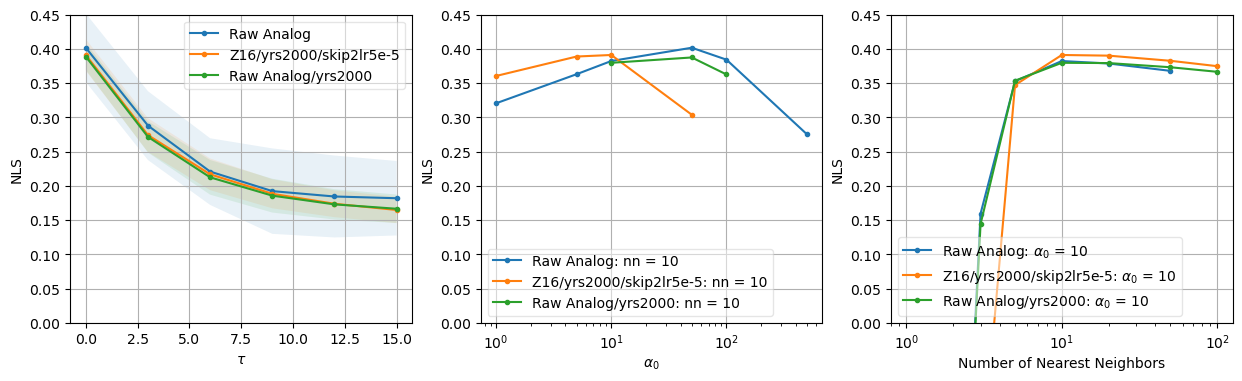

In [24]:
runs = {'Raw Analog' : '/scratchx/gmiloshe/Climate-Learning/VAE/xforanalogs/NA24by48/global_logit/yrs500/interT15/'
         ,'Z16/yrs2000/skip2lr5e-5' : '/scratchx/gmiloshe/Climate-Learning/VAE/xforanalogs/ZGonlyNA24by48/Z16/yrs2000/interT15fw20.1.20ZGskip2lr5e-5/'
         ,'Raw Analog/yrs2000' :'/scratchx/gmiloshe/Climate-Learning/VAE/xforanalogs/NA24by48/global_logit/yrs2000/interT15/'
        }

test=Compare_Scores(runs, setnn=10, setcheck=10, savename='./Images/analog')

Comparing with Gaussian loss

NAE ResNet (16)
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'allowselfanalogs': True, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [1, 2, 3, 5, 10, 20, 50, 100], 'delay': array([0, 1, 2, 3, 4, 5])}}}
0.39+-0.05, 5.0, 10
0.28+-0.04, 5.0, 10
0.22+-0.05, 5.0, 10
0.19+-0.05, 5.0, 10
0.18+-0.06, 1.0, 5
0.18+-0.06, 1.0, 5
NAE ResNet gaussian (16)
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'allowselfanalogs': True, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [1, 2, 3, 5, 10, 20, 50, 100], 'delay': array([0, 1, 2, 3, 4, 5])}}}
0.38+-0.10, 1.0, 10
0.25+-0.11, 1.0, 10
0.20+-0.10, 1.0, 10
0.20+-0.09, 1.0, 50
0.19+-0.08, 1.0, 50
0.18+-0.08, 1.0, 50
NAE Gaussian (16) KL.99.01
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'n

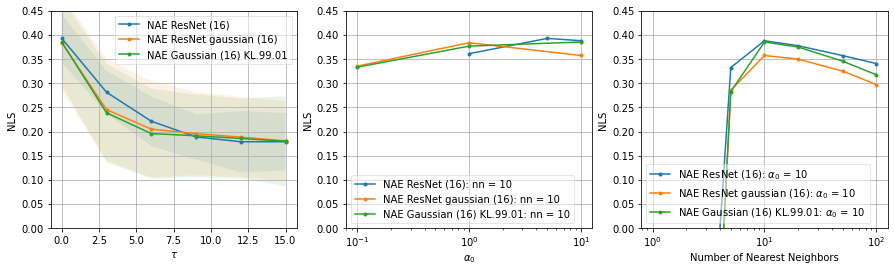

In [8]:
runs = {#'Raw Analog' : './xforanalogs/NA24by48/global_logit/yrs500/interT15/'
        #,'NA/Z8//fw20.1.20lrs4' : './xforanalogs/NA24by48/Z8/yrs500/interT15fw20.1.20lrs4/'
        #,'NA/Z8//fw20.4.20lrs4' : './xforanalogs/NA24by48/Z8/yrs500/interT15fw20.4.20lrs4/'
        #,'NA/Z8//fw20.1.20kl.5.5lrs4' : './xforanalogs/NA24by48/Z8/yrs500/interT15fw20.1.20kl.5.5lrs4/'
        #,'NA/Z8/yrs500/fw20.1.20skip2' : './xforanalogs/NA24by48/Z8/yrs500/interT15fw20.1.20skip2/'
        #,'NA/Z16//fw20.1.20lrs4' : './xforanalogs/NA24by48/Z16/yrs500/interT15fw20.1.20lrs4/'
        #,'NA/Z16//fw20.1.20kl.99.01skip2' : './xforanalogs/NA24by48/Z16/yrs500/interT15fw20.1.20kl.99.01skip2/'
        #,'NH/Z64/fw20.1.20lrs4' : './xforanalogs/NH24by128/Z64/yrs500/interT15fw20.1.20lrs4/'
        #,'ZG' : './xforanalogs/ZGonlyNA24by48/Z8/yrs500/interT15ZGlrs4/'
        #,'ZGfw1.1.1' : './xforanalogs/ZGonlyNA24by48/Z8/yrs500/interT15fw1.1.1ZGlrs4/'
        #,'ZGskip2' : './xforanalogs/ZGonlyNA24by48/Z8/yrs500/interT15ZGskip2/'
        #,'ZGskip2with10epochs' : './xforanalogs/ZGonlyNA24by48/Z8/yrs500/interT15ZGskip2with10epochs/'
        #,'ZGkl.99.01skip2' : './xforanalogs/ZGonlyNA24by48/Z8/yrs500/interT15ZGkl.99.01skip2/'
        'NAE ResNet (16)' : './xforanalogs/ZGonlyNA24by48/Z16/yrs500/interT15fw20.1.20ZGskip2/'
        #,'Z64/fw1.1.1' : './xforanalogs/ZGonlyNA24by48/Z16/yrs500/interT15fw1.1.1ZGlrs4/'
        #,'NAE (64)' : './xforanalogs/ZGonlyNA24by48/Z64/yrs500/interT15fw20.1.20ZGlrs4/'
        #,'Z64/fw1.1.1epoch10' : './xforanalogs/ZGonlyNA24by48/Z64/yrs500/interT15fw1.1.1ZGepoch10lrs4/'
        #,'Z64/fw20.1.20epoch10skip2' :'./xforanalogs/ZGonlyNA24by48/Z64/yrs500/interT15fw20.1.20ZG10epochsskip2/'
        , 'NAE ResNet gaussian (16)' : './xforanalogsL2loss/ZGonlyNA24by48/Z16/yrs500/interT15fw20.1.20skip2epochs100/'
        #, 'NAE gaussian (8)' : './xforanalogsL2loss/ZGonlyNA24by48/Z8/yrs500/interT15fw20.1.20skip2/'
        #, 'NAE Gaussian (16) KL11epoch1000' : './xforanalogsL2loss/ZGonlyNA24by48/Z16/yrs500/interT15fw20.1.20kl1.1.skip2epochs1000/'
        #, 'NAE Gaussian (16) KL11epoch10000' : 'xforanalogsL2loss/ZGonlyNA24by48/Z16/yrs500/interT15fw20.1.20kl1.1.skip2/'
        , 'NAE Gaussian (16) KL.99.01'   :'xforanalogsL2loss/ZGonlyNA24by48/Z16/yrs500/interT15fw20.1.20kl.99.01lr1e-3skip2/'
        }

test=Compare_Scores(runs, setnn=10, setcheck=10, savename='./Images/analog')

Comparisons between 1 percent and 5 percent, 3 day and 1 day Markov chains

Raw Analog France
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'windwsize': 30, 'start_calendar_day': None, 'start_day_set': 'va', 'allowselfanalogs': True, 'removeoutsidemovingwindow': False, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [2, 3, 5, 10, 20, 50], 'delay': array([0, 1, 2, 3, 4, 5]), 'num_steps': None}}}
here :  nn
2    -0.654385
3     0.147260
5     0.348281
10    0.376861
20    0.376024
50    0.365412
Name: 0, dtype: float64
0.40+-0.03, 50.0, 10
0.29+-0.02, 50.0, 10
0.22+-0.02, 50.0, 10
0.19+-0.02, 10.0, 20
0.18+-0.02, 10.0, 10
0.18+-0.03, 10.0, 10
Raw Analog France daily
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'windwsize': 30, 'start_calendar_day': None, 'start_day_set': 'va', 'allowselfanalogs': True, 'removeoutsidemovingwindow': False, 'RunNeigh

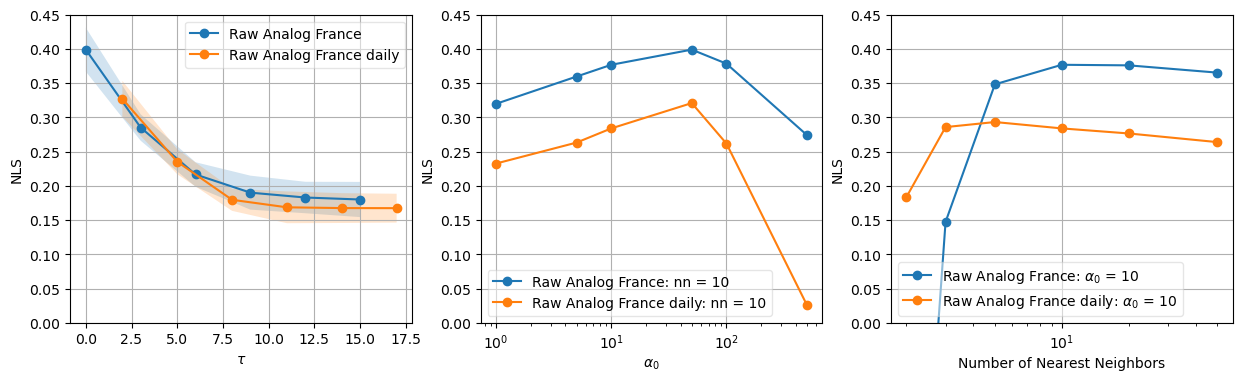

In [25]:
runs = { 'Raw Analog France' : '/scratchx/gmiloshe/Climate-Learning/VAE/xforanalogs/5fold/T15/NAE/France/yrs500/Z0/globa_logit/'
        #,'Raw Analog France 5%' : './xforanalogs/NA24by48/global_logit/yrs500/interT15/'
        #,'NAE ResNet (16) France' : './xforanalogs/ZGonlyNA24by48/Z16/yrs500/interT15fw20.1.20ZGskip2/'
          #'Raw Analog Scandinavia 5%' : './xforanalogs/ZGonlyNA24by48/Scandinavia/global_logit/yrs500/interT15/'
         #, 'NAE ResNet (16) Scandinavia 5%' : './xforanalogs/ZGonlyNA24by48/Scandinavia/Z16/yrs500/interT15fw20.1.20skip2/'
         #, 'Raw Analog Scandinavia 1%' : './xforanalogs/ZGonlyNA24by48/Scandinavia/global_logit/yrs500/Per1interT15/'
         #, 'North Atlantic ResNet (16) 1%' : './xforanalogs/ZGonlyNA24by48/Scandinavia/Z16/yrs500/Per1interT15fw20.1.20skip2/'
         #, 'Raw Analog France daily 1%' : ['./xforanalogs/NA24by48/global_logit/yrs500/interT15daily1percent/',2]
         #, 'Raw Analog France daily 5%' : ['./xforanalogs/NA24by48/global_logit/yrs500/interT15daily/',2]
         , 'Raw Analog France daily' : ['/scratchx/gmiloshe/Climate-Learning/VAE/xforanalogs/5fold/T15/NAE/France/yrs500/Z0/global_logit_daily/',2]
        }

test=Compare_Scores(runs, setnn=10, setcheck=10, savename='./Images/SWG1dvs3d', marker='o', linestyle='solid', alpha=0.2, dpi=200)

Comparing France and Scandinavia

Raw Analog France 5%
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'windwsize': 30, 'start_calendar_day': None, 'start_day_set': 'va', 'allowselfanalogs': True, 'removeoutsidemovingwindow': False, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [2, 3, 5, 10, 20, 50], 'delay': array([0, 1, 2, 3, 4, 5]), 'num_steps': None}}}
here :  nn
2    -0.645287
3     0.159361
5     0.352837
10    0.382369
20    0.378730
50    0.367985
Name: 0, dtype: float64
0.40+-0.05, 50.0, 10
0.29+-0.05, 50.0, 10
0.22+-0.05, 50.0, 10
0.19+-0.06, 10.0, 10
0.18+-0.06, 10.0, 10
0.18+-0.05, 10.0, 10
NAE ResNet (16) France
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'allowselfanalogs': True, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [1, 2, 3, 5, 10, 20, 50, 100]

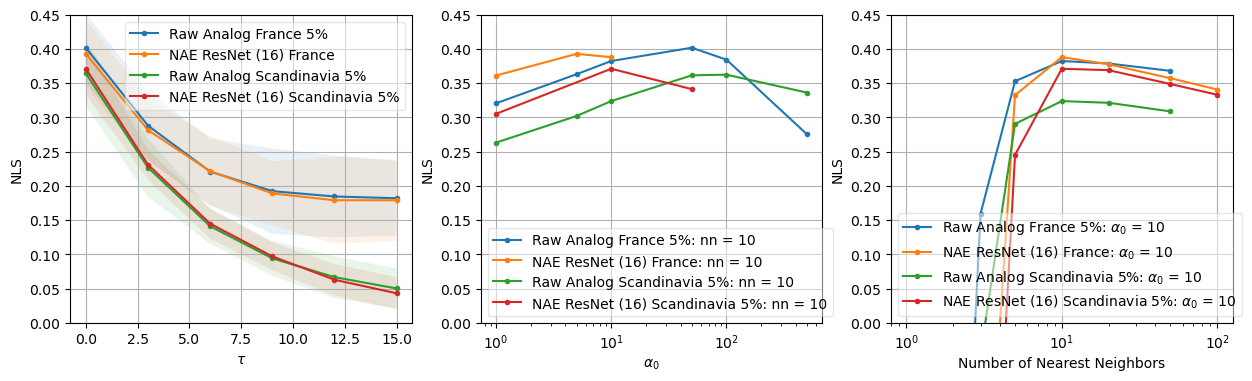

In [26]:
runs = {'Raw Analog France 5%' : '/scratchx/gmiloshe/Climate-Learning/VAE/xforanalogs/NA24by48/global_logit/yrs500/interT15/'
        ,'NAE ResNet (16) France' : '/scratchx/gmiloshe/Climate-Learning/VAE/xforanalogs/ZGonlyNA24by48/Z16/yrs500/interT15fw20.1.20ZGskip2/'
        ,  'Raw Analog Scandinavia 5%' : '/scratchx/gmiloshe/Climate-Learning/VAE/xforanalogs/ZGonlyNA24by48/Scandinavia/global_logit/yrs500/interT15/'
         , 'NAE ResNet (16) Scandinavia 5%' : '/scratchx/gmiloshe/Climate-Learning/VAE/xforanalogs/ZGonlyNA24by48/Scandinavia/Z16/yrs500/interT15fw20.1.20skip2/'
        }

test=Compare_Scores(runs, setnn=10, setcheck=10, savename='./Images/analog')

NAE for France
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'windwsize': 30, 'start_calendar_day': None, 'start_day_set': 'va', 'allowselfanalogs': True, 'removeoutsidemovingwindow': False, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [2, 3, 5, 10, 20, 50], 'delay': array([0, 1, 2, 3, 4, 5]), 'num_steps': None}}}
here :  nn
2    -0.654385
3     0.147260
5     0.348281
10    0.376861
20    0.376024
50    0.365412
Name: 0, dtype: float64
0.40+-0.03, 50.0, 10
0.29+-0.02, 50.0, 10
0.22+-0.02, 50.0, 10
0.19+-0.02, 10.0, 20
0.18+-0.02, 10.0, 10
0.18+-0.03, 10.0, 10
NH for Frnce
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'windwsize': 30, 'start_calendar_day': None, 'start_day_set': 'va', 'allowselfanalogs': True, 'removeoutsidemovingwindow': False, 'RunNeighbors_kwargs': 

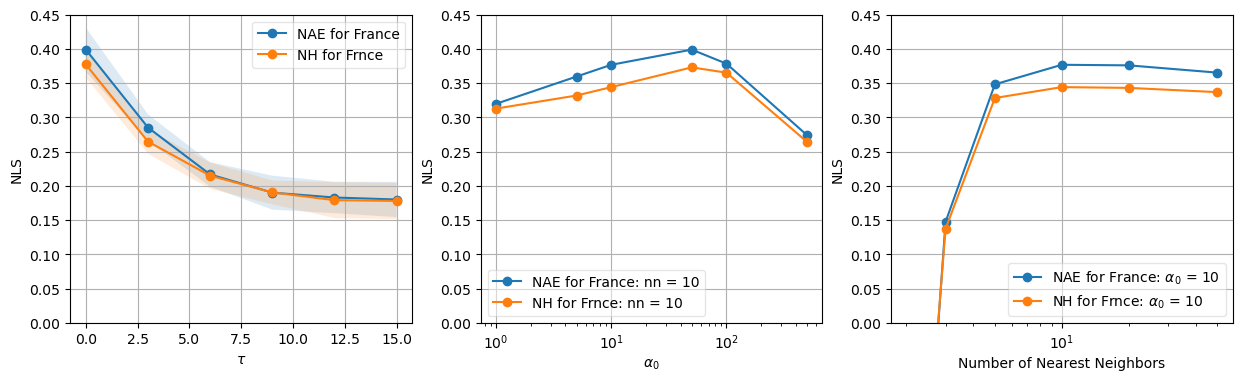

In [27]:
runs = {#'NAE for France' : './xforanalogs/NA24by48/global_logit/yrs500/interT15/'
        'NAE for France' : '/scratchx/gmiloshe/Climate-Learning/VAE/xforanalogs/5fold/T15/NAE/France/yrs500/Z0/globa_logit/',
        #,'NH for France' : './xforanalogs/NH24by128/global_logit/yrs500/interT15/'
        'NH for Frnce' : '/scratchx/gmiloshe/Climate-Learning/VAE/xforanalogs/5fold/T15/NH/France/yrs500/Z0/global_logit/'
        
        #,'North Hemisphere shallow (16)' : './xforanalogs/NH24by128/Z16/yrs500/interT15L2Conv2dense1linear/'
}
        
test=Compare_Scores(runs, setnn=10, setcheck=10, savename='./Images/SWGNAEvsNH', marker='o', linestyle='solid', alpha=0.15, dpi=200)

France 500 yrs
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'windwsize': 30, 'start_calendar_day': None, 'start_day_set': 'va', 'allowselfanalogs': True, 'removeoutsidemovingwindow': False, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [2, 3, 5, 10, 20, 50], 'delay': array([0, 1, 2, 3, 4, 5]), 'num_steps': None}}}
here :  nn
2    -0.645287
3     0.159361
5     0.352837
10    0.382369
20    0.378730
50    0.367985
Name: 0, dtype: float64
0.40+-0.05, 50.0, 10
0.29+-0.05, 50.0, 10
0.22+-0.05, 50.0, 10
0.19+-0.06, 10.0, 10
0.18+-0.06, 10.0, 10
0.18+-0.05, 10.0, 10
France 100 yrs
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'windwsize': 30, 'start_calendar_day': None, 'start_day_set': 'va', 'allowselfanalogs': True, 'removeoutsidemovingwindow': False, 'RunNeighbors_kwargs'

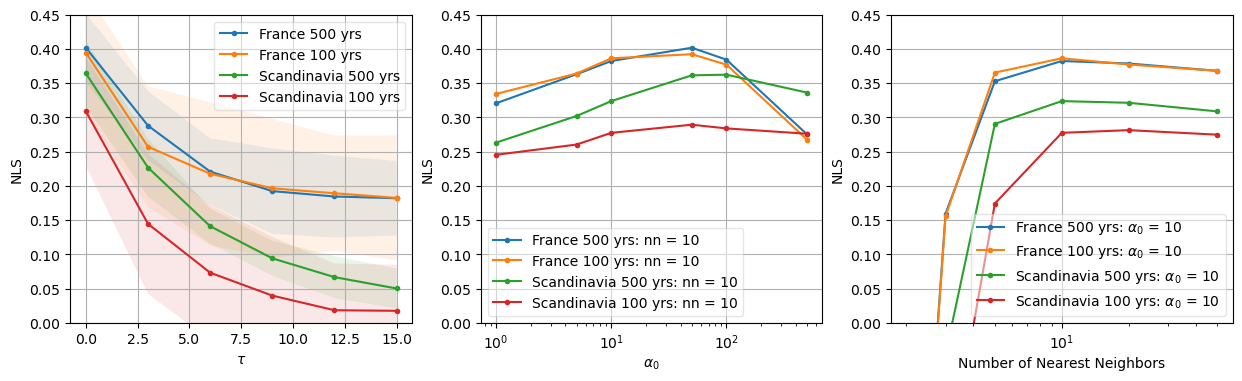

In [28]:
runs = {'France 500 yrs' : '/scratchx/gmiloshe/Climate-Learning/VAE/xforanalogs/NA24by48/global_logit/yrs500/interT15/'
        ,'France 100 yrs' : '/scratchx/gmiloshe/Climate-Learning/VAE/xforanalogs/NA24by48/global_logit/yrs100/interT15/'
        ,'Scandinavia 500 yrs' : '/scratchx/gmiloshe/Climate-Learning/VAE/xforanalogs/ZGonlyNA24by48/Scandinavia/global_logit/yrs500/interT15'
        ,'Scandinavia 100 yrs' : '/scratchx/gmiloshe/Climate-Learning/VAE/xforanalogs/ZGonlyNA24by48/Scandinavia/global_logit/yrs100/interT15'
}
        
test=Compare_Scores(runs, setnn=10, setcheck=10, savename='./Images/analog_NAEvsNH')

Raw Analog 500 yrs
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'windwsize': 30, 'start_calendar_day': None, 'start_day_set': 'va', 'allowselfanalogs': True, 'removeoutsidemovingwindow': False, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [2, 3, 5, 10, 20, 50], 'delay': array([0, 1, 2, 3, 4, 5]), 'num_steps': None}}}
here :  nn
2    -0.839688
3    -0.045821
5     0.290512
10    0.323793
20    0.321331
50    0.308769
Name: 0, dtype: float64
0.36+-0.05, 100.0, 20
0.23+-0.04, 100.0, 10
0.14+-0.03, 100.0, 10
0.09+-0.03, 100.0, 10
0.07+-0.03, 50.0, 10
0.05+-0.03, 50.0, 10
Raw Analog 100 yrs
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'windwsize': 30, 'start_calendar_day': None, 'start_day_set': 'va', 'allowselfanalogs': True, 'removeoutsidemovingwindow': False, 'RunNeigh

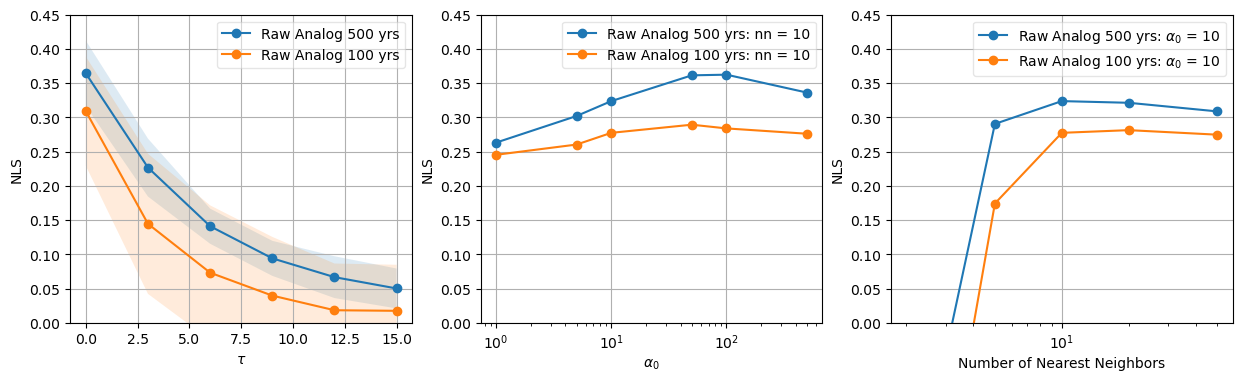

In [29]:
runs = {'Raw Analog 500 yrs' : '/scratchx/gmiloshe/Climate-Learning/VAE/xforanalogs/ZGonlyNA24by48/Scandinavia/global_logit/yrs500/interT15'
        ,'Raw Analog 100 yrs' : '/scratchx/gmiloshe/Climate-Learning/VAE/xforanalogs/ZGonlyNA24by48/Scandinavia/global_logit/yrs100/interT15'
}
        
test=Compare_Scores(runs, setnn=10, setcheck=10, savename='./Images/Scandinavia_100vs500', marker='o', linestyle='solid', alpha=0.15, dpi=200)

France SWG
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'windwsize': 30, 'start_calendar_day': None, 'start_day_set': 'va', 'allowselfanalogs': True, 'removeoutsidemovingwindow': False, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [2, 3, 5, 10, 20, 50], 'delay': array([0, 1, 2, 3, 4, 5]), 'num_steps': None}}}
here :  nn
2    -0.645287
3     0.159361
5     0.352837
10    0.382369
20    0.378730
50    0.367985
Name: 0, dtype: float64
0.40+-0.05, 50.0, 10
0.29+-0.05, 50.0, 10
0.22+-0.05, 50.0, 10
0.19+-0.06, 10.0, 10
0.18+-0.06, 10.0, 10
0.18+-0.05, 10.0, 10
Scandinavia SWG
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'windwsize': 30, 'start_calendar_day': None, 'start_day_set': 'va', 'allowselfanalogs': True, 'removeoutsidemovingwindow': False, 'RunNeighbors_kwargs': {

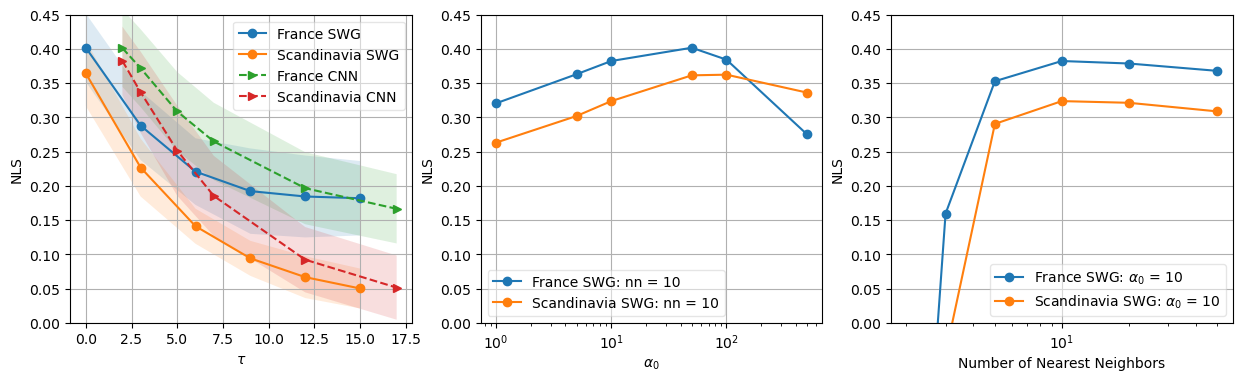

In [30]:

runs = {'France SWG' : '/scratchx/gmiloshe/Climate-Learning/VAE/xforanalogs/NA24by48/global_logit/yrs500/interT15/'
        ,'Scandinavia SWG' : '/scratchx/gmiloshe/Climate-Learning/VAE/xforanalogs/ZGonlyNA24by48/Scandinavia/global_logit/yrs500/interT15/'
        }

fig2, ax = Compare_Scores(runs, setnn=10, setcheck=10, savename='./Images/Scandinavia500vs100', marker='o', linestyle='solid', alpha=0.15, dpi=200)

test=Compare_CNNs(folder, ['/homedata/gmiloshe/old.Climate-Learning/PLASIM/xmodels/u1yrs500/','/homedata/gmiloshe/old.Climate-Learning/PLASIM/xmodels/Scandinavia/u1yrs500'], fig2=fig2, ax=ax, savename='./Images/Scandinavia500vs100', marker='>', linestyle='dashed', alpha=0.15, dpi=200)

France SWG
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'windwsize': 30, 'start_calendar_day': None, 'start_day_set': 'va', 'allowselfanalogs': True, 'removeoutsidemovingwindow': False, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [2, 3, 5, 10, 20, 50], 'delay': array([0, 1, 2, 3, 4, 5]), 'num_steps': None}}}
here :  nn
2    -0.654385
3     0.147260
5     0.348281
10    0.376861
20    0.376024
50    0.365412
Name: 0, dtype: float64
0.40+-0.03, 50.0, 10
0.29+-0.02, 50.0, 10
0.22+-0.02, 50.0, 10
0.19+-0.02, 10.0, 20
0.18+-0.02, 10.0, 10
0.18+-0.03, 10.0, 10
France SWG VAE
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'windwsize': 30, 'start_calendar_day': None, 'start_day_set': 'va', 'allowselfanalogs': True, 'removeoutsidemovingwindow': False, 'RunNeighbors_kwargs': {'

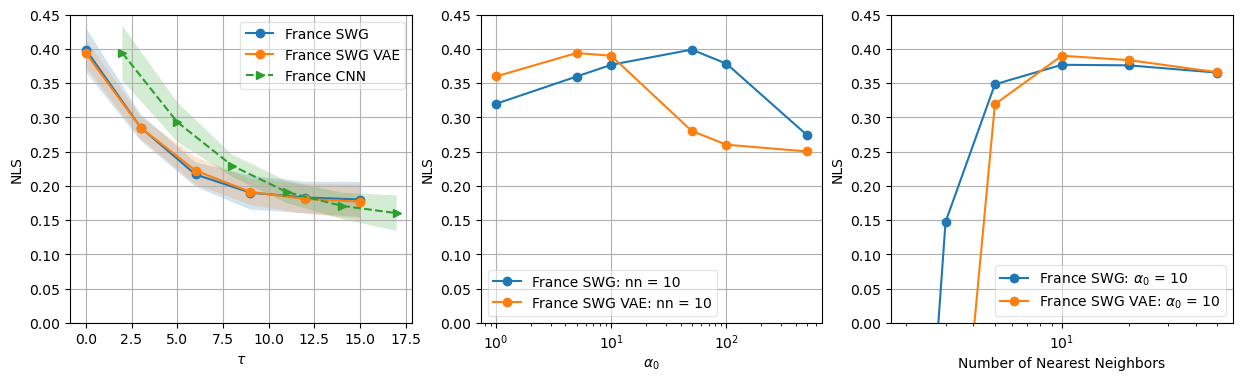

In [36]:

runs = {#'France SWG' : '/scratchx/gmiloshe/Climate-Learning/VAE/xforanalogs/NA24by48/global_logit/yrs500/interT15/',
        'France SWG' : '/scratchx/gmiloshe/Climate-Learning/VAE/xforanalogs/5fold/T15/NAE/France/yrs500/Z0/globa_logit/'
        ,'France SWG VAE' : '/scratchx/gmiloshe/Climate-Learning/VAE/xforanalogs/5fold/T15/NAE/France/yrs500/Z16/ZGskip2/'
        }
fig2, ax = Compare_Scores(runs, setnn=10, setcheck=10, savename='./Images/SWGvsCNNFrance', marker='o', linestyle='solid', alpha=0.2, dpi=200)

test=Compare_CNNs(folder, [#'/homedata/gmiloshe/old.Climate-Learning/PLASIM/xmodels/u1yrs500/',
                          #'/homedata/gmiloshe/old.Climate-Learning/PLASIM/xmodels/NAEu1yrs500/'
                          '/homedata/gmiloshe/old.Climate-Learning/PLASIM/xmodels/5fold/T15/NAE/France/yrs500/'], fig2=fig2, ax=ax, savename='./Images/SWGvsCNNFrance', marker='>', linestyle='dashed', alpha=0.2, dpi=200)

Scandinavia SWG
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'windwsize': 30, 'start_calendar_day': None, 'start_day_set': 'va', 'allowselfanalogs': True, 'removeoutsidemovingwindow': False, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [2, 3, 5, 10, 20, 50], 'delay': array([0, 1, 2, 3, 4, 5]), 'num_steps': None}}}
here :  nn
2    -0.884352
3    -0.103384
5     0.278790
10    0.322065
20    0.316496
50    0.306803
Name: 0, dtype: float64
0.36+-0.03, 100.0, 20
0.22+-0.04, 100.0, 10
0.14+-0.04, 100.0, 10
0.09+-0.02, 100.0, 10
0.07+-0.02, 50.0, 10
0.05+-0.02, 50.0, 10
k = 0
runs_grouped_list[k]['args'] = {}


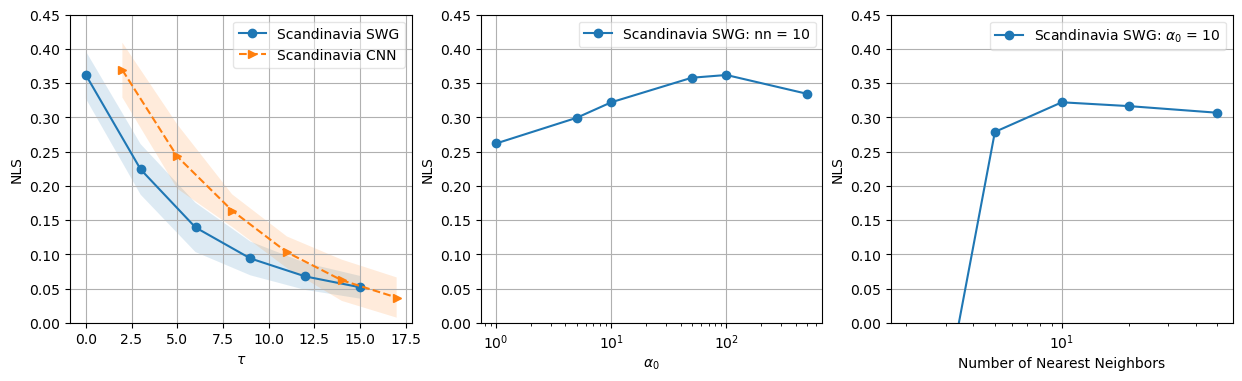

In [32]:

runs = {#'Scandinavia SWG' : '/scratchx/gmiloshe/Climate-Learning/VAE/xforanalogs/ZGonlyNA24by48/Scandinavia/global_logit/yrs500/interT15/',
        'Scandinavia SWG': '/scratchx/gmiloshe/Climate-Learning/VAE/xforanalogs/5fold/T15/NAE/Scandinavia/yrs500/Z0/globa_logit/'
        }

fig2, ax = Compare_Scores(runs, setnn=10, setcheck=10, savename='./Images/SWGvsCNNScand', marker='o', linestyle='solid', alpha=0.15, dpi=200)

test=Compare_CNNs(folder, [#'/homedata/gmiloshe/old.Climate-Learning/PLASIM/xmodels/Scandinavia/u1yrs500',
                           #'/homedata/gmiloshe/old.Climate-Learning/PLASIM/xmodels/Scandinavia/NAEu1yrs500',
                           '/homedata/gmiloshe/old.Climate-Learning/PLASIM/xmodels/5fold/T15/NAE/Scandinavia/yrs500/'], fig2=fig2, ax=ax, savename='./Images/SWGvsCNNScand', marker='>', linestyle='dashed', alpha=0.15, dpi=200)

France SWG
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'windwsize': 30, 'start_calendar_day': None, 'start_day_set': 'va', 'allowselfanalogs': True, 'removeoutsidemovingwindow': False, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [2, 3, 5, 10, 20, 50], 'delay': array([0, 1, 2, 3, 4, 5]), 'num_steps': None}}}
here :  nn
2    -0.746112
3     0.061894
5     0.348489
10    0.382613
20    0.376278
50    0.366722
Name: 0, dtype: float64
0.39+-0.09, 50.0, 10
0.25+-0.08, 50.0, 10
0.21+-0.10, 10.0, 20
0.20+-0.10, 10.0, 50
0.19+-0.10, 10.0, 20
0.19+-0.10, 10.0, 20
k = 0
runs_grouped_list[k]['args'] = {}


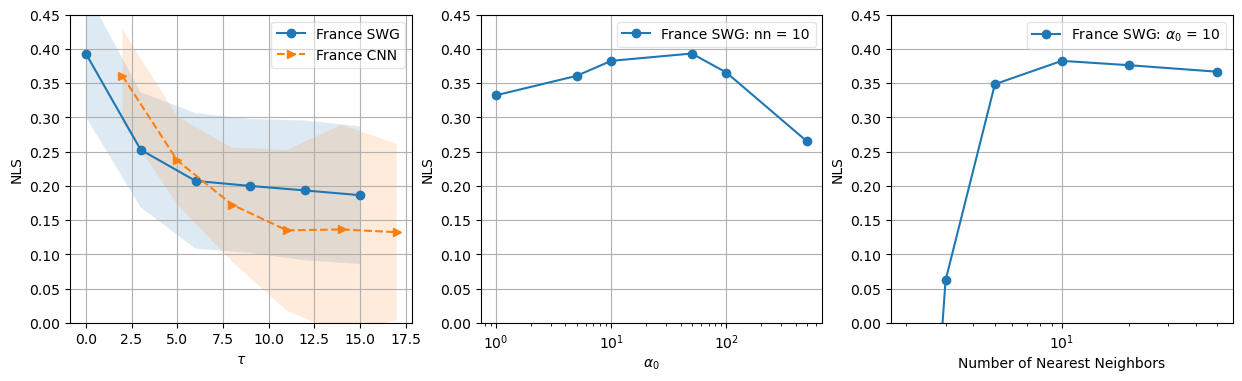

In [33]:

runs = {'France SWG' : '/scratchx/gmiloshe/Climate-Learning/VAE/xforanalogs/5fold/T15/NAE/France/yrs100/Z0/global_logit'
        }
savefile = './Images/SWGvsCNNFranceD100'
fig2, ax = Compare_Scores(runs, setnn=10, setcheck=10, savename=savefile, marker='o', linestyle='solid', alpha=0.15, dpi=200)

test = Compare_CNNs(folder, ['/homedata/gmiloshe/old.Climate-Learning/PLASIM/xmodels/5fold/T15/NAE/France/yrs100'], fig2=fig2, ax=ax, savename=savefile, marker='>', linestyle='dashed', alpha=0.15, dpi=200)

Scandinavia SWG
dict_keys(['committor', 'skill', 'RunFolds_kwargs_default'])
{'nfield': 0, 'input_set': 'va', 'bulk_set': 'tr', 'RunCheckpoints_kwargs': {'windwsize': 30, 'start_calendar_day': None, 'start_day_set': 'va', 'allowselfanalogs': True, 'removeoutsidemovingwindow': False, 'RunNeighbors_kwargs': {'num_Traj': 10000, 'T': 15, 'chain_step': 3, 'neighbors': [2, 3, 5, 10, 20, 50], 'delay': array([0, 1, 2, 3, 4, 5]), 'num_steps': None}}}
here :  nn
2    -1.186302
3    -0.268660
5     0.189078
10    0.266281
20    0.273896
50    0.269513
Name: 0, dtype: float64
0.31+-0.06, 50.0, 20
0.15+-0.07, 50.0, 20
0.07+-0.04, 50.0, 20
0.04+-0.02, 50.0, 20
0.02+-0.02, 50.0, 20
0.02+-0.03, 50.0, 10
k = 0
runs_grouped_list[k]['args'] = {}


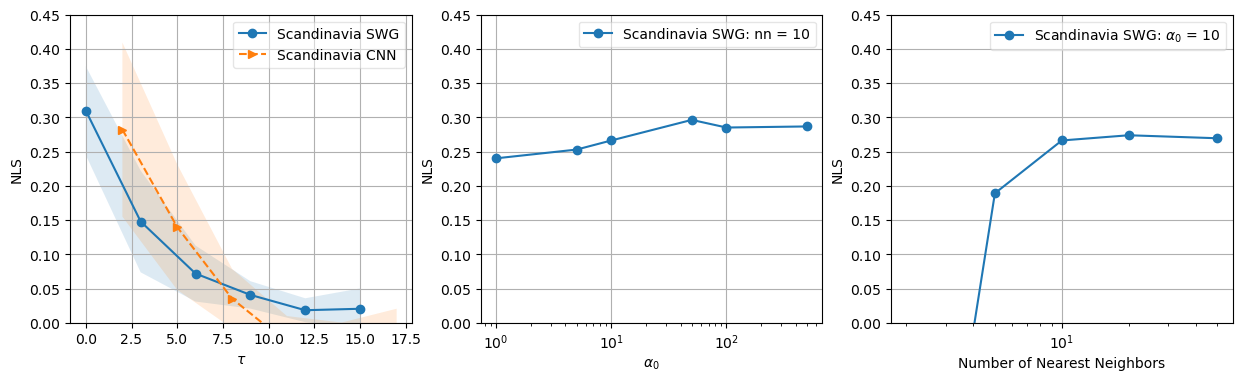

In [34]:

runs = {#'Scandinavia SWG' : '/scratchx/gmiloshe/Climate-Learning/VAE/xforanalogs/ZGonlyNA24by48/Scandinavia/global_logit/yrs100/interT15/',
        'Scandinavia SWG' : '/scratchx/gmiloshe/Climate-Learning/VAE/xforanalogs/5fold/T15/NAE/Scandinavia/yrs100/Z0/global_logit/'
        }

savefile = './Images/SWGvsCNNScandinaviaD100'
fig2, ax = Compare_Scores(runs, setnn=10, setcheck=10, savename=savefile, marker='o', linestyle='solid', alpha=0.15, dpi=200)

runs_grouped_list = Compare_CNNs(folder, [#'/homedata/gmiloshe/old.Climate-Learning/PLASIM/xmodels/Scandinavia/NAEu1yrs100',
                                          '/homedata/gmiloshe/old.Climate-Learning/PLASIM/xmodels/5fold/T15/NAE/Scandinavia/yrs100'], 
                                 fig2=fig2, ax=ax, savename=savefile, marker='>', linestyle='dashed', alpha=0.15, dpi=200)

k = 0
runs_grouped_list[k]['args'] = {}
tau_index = 0
k = 0
runs_grouped_list[k]['args'] = {}
k = 0
runs_grouped_list[k]['args'] = {}
k = 0
runs_grouped_list[k]['args'] = {}
tau_index = 0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


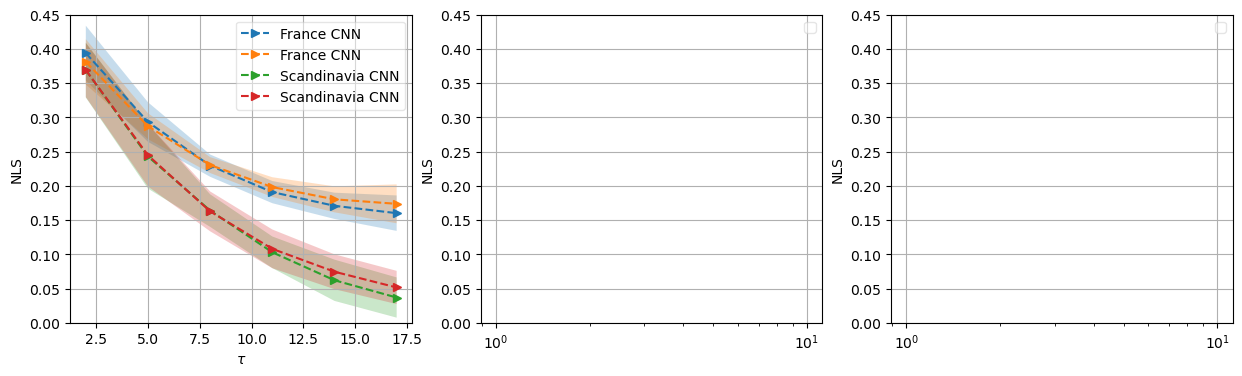

In [13]:
test = Compare_CNNs(folder, ['/homedata/gmiloshe/old.Climate-Learning/PLASIM/xmodels/5fold/T15/NAE/France/yrs500/',
                             '/homedata/gmiloshe/old.Climate-Learning/PLASIM/xmodels/5fold/T15/NAE/France/u10/yrs500/',
                             '/homedata/gmiloshe/old.Climate-Learning/PLASIM/xmodels/5fold/T15/NAE/Scandinavia/yrs500/',
                             '/homedata/gmiloshe/old.Climate-Learning/PLASIM/xmodels/5fold/T15/NAE/Scandinavia/u10/yrs500/'], 
                    savename='./Images/analog', marker='>', linestyle='dashed', alpha=0.25)